## Predicting Employee Attrition    

In recent years, attention has increasingly been paid to human resources (HR), since worker quality and skills represent a growth factor and a real competitive advantage for companies. After proving its mettle in sales and marketing, artificial intelligence is also becoming central to employee-related decisions within HR management. Organizational growth largely depends on staff retention. Losing employees frequently impacts the morale of the organization and hiring new employees is more expensive than retaining existing ones. <br>

You are working as a data scientist with HR Department of a large insurance company focused on sales team attrition. Insurance sales teams help insurance companies generate new business by contacting potential customers and selling one or more types of insurance. The department generally sees high attrition and thus staffing becomes a crucial aspect. <br>

To aid staffing, you are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization in the upcoming two quarters (01 Jan 2018 - 01 July 2018) or not, given:<br>


1. Demographics of the employee (city, age, gender etc.) <br>
2. Tenure information (joining date, Last Date)<br>
3. Historical data regarding the performance of the employee (Quarterly rating, Monthly business acquired, designation, salary)<br>

#### Train Data


MMMM-YY : Reporting Date (Monthly) <br>
Emp_ID : Unique id for employees<br>
Age : Age of the employee<br>
Gender : Gender of the employee<br>
City : City Code of the employee<br>
Education_Level : Bachelor, Master or College<br>
Salary : Salary of the employee<br>
Dateofjoining : Joining date for the employee<br>
LastWorkingDate : Last date of working for the employee<br>
Joining Designation : Designation of the employee at the time of joining<br>
Designation : Designation of the employee at the time of reporting<br>
Total_Business_Value : The total business value acquired by the employee in a month<br>
(negative business indicates cancellation/refund of sold insurance policies)<br> 
Quarterly Rating : Quarterly rating of the employee: 1,2,3,4 (higher is better)<br>


#### Test Data
Emp_ID : Unique Id for the employees

#### Submission Format

Emp_ID : Employee ID <br>
Target : <br>
0: if the employee does not leave the organization,<br>1: if the employee leaves the organization<br>

#### Evaluation Metric:
The evaluation metric for this competition is macro f1_score

In [21]:
!pip install xgboost

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGBC

from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p


import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [23]:
train = pd.read_csv("train.csv")
train.head()

MMM-YY  Emp_ID  Age Gender City Education_Level  Salary Dateofjoining  \
0  2016-01-01       1   28   Male  C23          Master   57387    2015-12-24   
1  2016-02-01       1   28   Male  C23          Master   57387    2015-12-24   
2  2016-03-01       1   28   Male  C23          Master   57387    2015-12-24   
3  2017-11-01       2   31   Male   C7          Master   67016    2017-11-06   
4  2017-12-01       2   31   Male   C7          Master   67016    2017-11-06   

  LastWorkingDate  Joining Designation  Designation  Total Business Value  \
0             NaN                    1            1               2381060   
1             NaN                    1            1               -665480   
2      2016-03-11                    1            1                     0   
3             NaN                    2            2                     0   
4             NaN                    2            2                     0   

   Quarterly Rating  
0                 2  
1                 2  
2                 2  
3                 1  
4                 1

In [24]:
train.shape

(19104, 13)

### Missing Values

In [25]:
train.isnull().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [26]:
train.describe()

Emp_ID           Age         Salary  Joining Designation  \
count  19104.000000  19104.000000   19104.000000         19104.000000   
mean    1415.591133     34.650283   65652.025126             1.690536   
std      810.705321      6.264471   30914.515344             0.836984   
min        1.000000     21.000000   10747.000000             1.000000   
25%      710.000000     30.000000   42383.000000             1.000000   
50%     1417.000000     34.000000   60087.000000             1.000000   
75%     2137.000000     39.000000   83969.000000             2.000000   
max     2788.000000     58.000000  188418.000000             5.000000   

        Designation  Total Business Value  Quarterly Rating  
count  19104.000000          1.910400e+04      19104.000000  
mean       2.252670          5.716621e+05          2.008899  
std        1.026512          1.128312e+06          1.009832  
min        1.000000         -6.000000e+06          1.000000  
25%        1.000000          0.000000e+00          1.000000  
50%        2.000000          2.500000e+05          2.000000  
75%        3.000000          6.997000e+05          3.000000  
max        5.000000          3.374772e+07          4.000000

In [27]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [28]:
list(train.Gender.unique())

['Male', 'Female']

In [29]:
list(train["Joining Designation"].unique())

[1, 2, 3, 4, 5]

In [30]:
list(train.Education_Level.unique())

['Master', 'College', 'Bachelor']

In [31]:
list(train.Designation.unique())

[1, 2, 3, 4, 5]

In [32]:
list(train["Quarterly Rating"].unique())

[2, 1, 4, 3]

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [34]:
numerical_feature = train.describe(include=["int64"]).columns

print(list(numerical_feature))

['Emp_ID', 'Age', 'Salary', 'Joining Designation', 'Designation', 'Total Business Value', 'Quarterly Rating']


In [35]:
categorical_features = train.describe(include=["object"]).columns

print(list(categorical_features))

['MMM-YY', 'Gender', 'City', 'Education_Level', 'Dateofjoining', 'LastWorkingDate']


Index(['MMM-YY', 'Gender', 'City', 'Education_Level', 'Dateofjoining',
       'LastWorkingDate'],
      dtype='object')


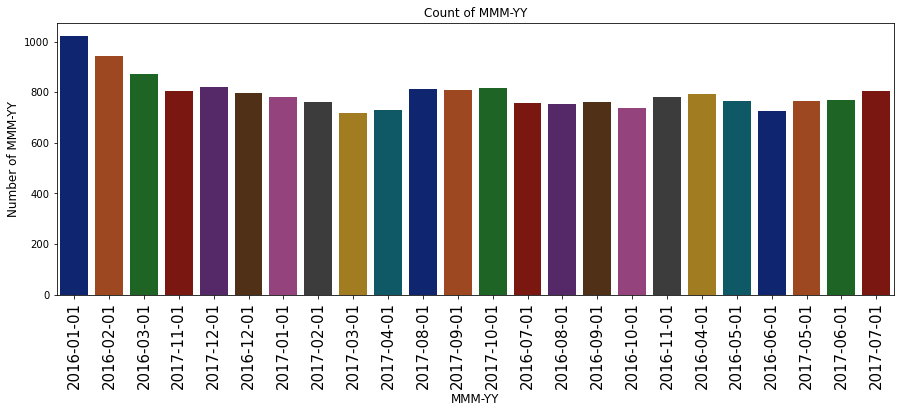

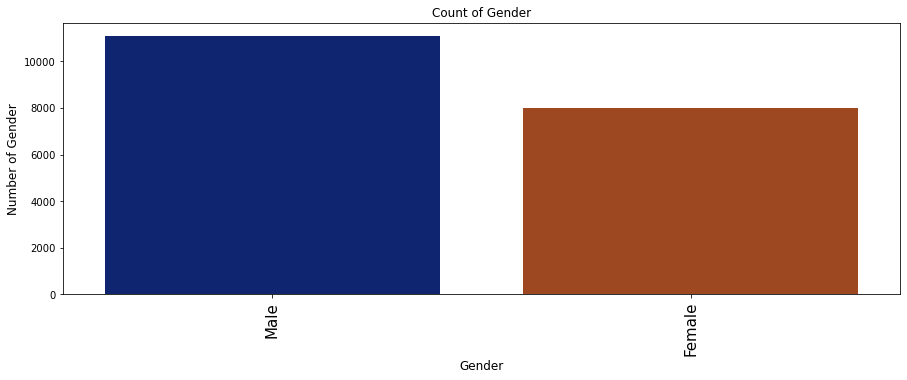

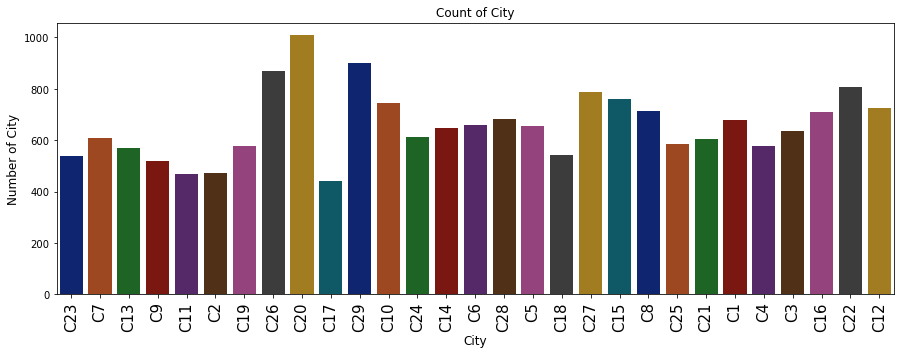

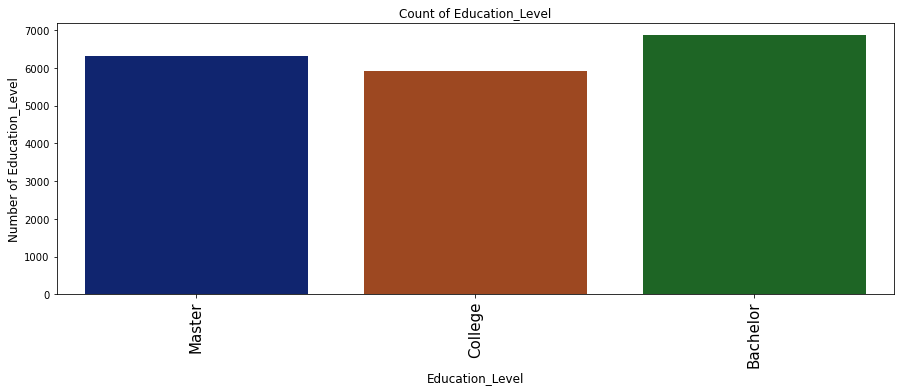

In [36]:
print(categorical_features)



for idx, column in enumerate(categorical_features[:-2]):
    plt.figure(figsize=(15, 5))
    df = train.copy()
    unique = df[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=train, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 90, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)
    plt.show()

In [37]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

Text(0.5, 1.0, 'Monthly Income by Gender')

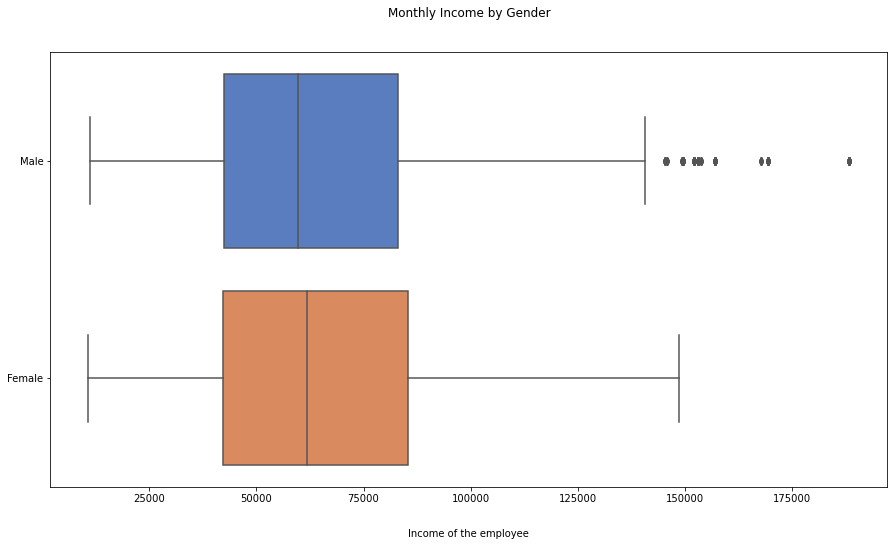

In [38]:
plt.subplots(figsize = (15,8))
ax = sns.boxplot(data = train,
           y = "Gender",
           x = "Salary",
           palette = "muted")

ax.set_xlabel("Income of the employee", labelpad = 25)
ax.set_ylabel(None)
ax.set_title("Monthly Income by Gender", pad = 35)

## Data preprocessing

In [39]:
id= []
for i in train.Emp_ID.unique():
    if len(train[train.Emp_ID ==i].Designation.unique()) >1:
        print(i)
        id.append(i)
    else:
        print(i, ": no designation change")
    
    

1 : no designation change
2 : no designation change
4 : no designation change
5 : no designation change
6 : no designation change
8 : no designation change
11 : no designation change
12 : no designation change
13 : no designation change
14 : no designation change
16 : no designation change
17 : no designation change
18 : no designation change
20 : no designation change
21 : no designation change
22 : no designation change
24 : no designation change
25 : no designation change
26
29 : no designation change
30 : no designation change
31 : no designation change
34 : no designation change
35 : no designation change
36 : no designation change
37 : no designation change
38 : no designation change
39 : no designation change
40 : no designation change
41 : no designation change
42 : no designation change
43 : no designation change
44 : no designation change
45 : no designation change
46 : no designation change
47 : no designation change
49 : no designation change
50 : no designation change
51 :

481 : no designation change
482 : no designation change
483 : no designation change
484 : no designation change
486 : no designation change
487 : no designation change
488 : no designation change
489 : no designation change
491 : no designation change
492 : no designation change
493 : no designation change
494 : no designation change
496 : no designation change
497 : no designation change
498 : no designation change
499 : no designation change
500 : no designation change
501 : no designation change
502 : no designation change
503 : no designation change
504 : no designation change
505 : no designation change
507 : no designation change
508 : no designation change
509 : no designation change
510 : no designation change
511 : no designation change
512 : no designation change
513 : no designation change
515 : no designation change
516 : no designation change
517 : no designation change
518 : no designation change
519 : no designation change
520 : no designation change
521 : no designation

838 : no designation change
839 : no designation change
840 : no designation change
841 : no designation change
842 : no designation change
843 : no designation change
844 : no designation change
845 : no designation change
847 : no designation change
848 : no designation change
849 : no designation change
850 : no designation change
851 : no designation change
852 : no designation change
853 : no designation change
855 : no designation change
856 : no designation change
858 : no designation change
859 : no designation change
860 : no designation change
863 : no designation change
864 : no designation change
865 : no designation change
866 : no designation change
867 : no designation change
868 : no designation change
869 : no designation change
870 : no designation change
871 : no designation change
872 : no designation change
873 : no designation change
874 : no designation change
875 : no designation change
876 : no designation change
877 : no designation change
879 : no designation

1341 : no designation change
1342 : no designation change
1343 : no designation change
1345 : no designation change
1347 : no designation change
1348 : no designation change
1349 : no designation change
1350 : no designation change
1351 : no designation change
1352 : no designation change
1353 : no designation change
1354 : no designation change
1356 : no designation change
1357 : no designation change
1358 : no designation change
1359 : no designation change
1360 : no designation change
1361 : no designation change
1362 : no designation change
1363 : no designation change
1364 : no designation change
1365 : no designation change
1366 : no designation change
1369 : no designation change
1370 : no designation change
1371 : no designation change
1372 : no designation change
1373 : no designation change
1374 : no designation change
1375 : no designation change
1376 : no designation change
1378 : no designation change
1379 : no designation change
1380 : no designation change
1381 : no desi

1844 : no designation change
1845 : no designation change
1846 : no designation change
1847 : no designation change
1848 : no designation change
1849 : no designation change
1850 : no designation change
1851 : no designation change
1852
1853 : no designation change
1854 : no designation change
1855 : no designation change
1856 : no designation change
1858 : no designation change
1859 : no designation change
1860 : no designation change
1861 : no designation change
1862 : no designation change
1863 : no designation change
1864 : no designation change
1865 : no designation change
1866 : no designation change
1867 : no designation change
1868 : no designation change
1869 : no designation change
1871 : no designation change
1872 : no designation change
1873 : no designation change
1874 : no designation change
1875 : no designation change
1876 : no designation change
1877
1878 : no designation change
1879 : no designation change
1880 : no designation change
1882 : no designation change
1883

2206 : no designation change
2207 : no designation change
2208 : no designation change
2209 : no designation change
2210 : no designation change
2211 : no designation change
2213 : no designation change
2214 : no designation change
2215 : no designation change
2216 : no designation change
2217 : no designation change
2218 : no designation change
2219 : no designation change
2220 : no designation change
2221 : no designation change
2223 : no designation change
2224 : no designation change
2225 : no designation change
2226 : no designation change
2227 : no designation change
2228 : no designation change
2229 : no designation change
2230 : no designation change
2231 : no designation change
2232 : no designation change
2233 : no designation change
2235 : no designation change
2236 : no designation change
2238 : no designation change
2239 : no designation change
2240 : no designation change
2241 : no designation change
2242 : no designation change
2245 : no designation change
2246 : no desi

2693 : no designation change
2694 : no designation change
2695 : no designation change
2696 : no designation change
2697 : no designation change
2698 : no designation change
2699 : no designation change
2700 : no designation change
2701 : no designation change
2702 : no designation change
2703 : no designation change
2704 : no designation change
2705 : no designation change
2706 : no designation change
2707 : no designation change
2708 : no designation change
2709 : no designation change
2710 : no designation change
2711 : no designation change
2712 : no designation change
2713 : no designation change
2714 : no designation change
2715 : no designation change
2716 : no designation change
2718 : no designation change
2719 : no designation change
2720 : no designation change
2721 : no designation change
2722 : no designation change
2723 : no designation change
2724 : no designation change
2725 : no designation change
2726 : no designation change
2727 : no designation change
2728 : no desi

Employees with change in designations

In [40]:
id

[26,
 54,
 60,
 98,
 275,
 307,
 320,
 368,
 434,
 537,
 568,
 580,
 582,
 638,
 716,
 789,
 888,
 1031,
 1050,
 1161,
 1165,
 1206,
 1249,
 1274,
 1316,
 1327,
 1770,
 1783,
 1817,
 1840,
 1852,
 1877,
 1918,
 2008,
 2070,
 2087,
 2198,
 2272,
 2390,
 2407,
 2543,
 2567,
 2625,
 2690]

In [41]:
city= []
for i in train.Emp_ID.unique():
    if len(train[train.Emp_ID ==i].City.unique()) >1:
        print(i)
        city.append(i)
    

In [42]:
city

[]

No change in the city

In [43]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [44]:
train['MMM-YY'] = train['MMM-YY'].str.replace('-','/')
train['Dateofjoining'] = train['Dateofjoining'].str.replace('-','/')
train['LastWorkingDate'] = train['LastWorkingDate'].str.replace('-','/')

In [45]:
train[["MMM-YY", "Dateofjoining"]] = train[["MMM-YY", "Dateofjoining"]].apply(pd.to_datetime)

In [46]:
train["LastWorkingDate"] = train["LastWorkingDate"].apply(pd.to_datetime)

In [47]:
train.dtypes

MMM-YY                  datetime64[ns]
Emp_ID                           int64
Age                              int64
Gender                          object
City                            object
Education_Level                 object
Salary                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Designation                      int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [48]:
train.isnull().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [49]:
train["LastWorkingDate"].replace({pd.NaT: 0}, inplace=True)

In [50]:
train["LastWorkingDate"] = train["LastWorkingDate"].apply(pd.to_datetime)

## Feature Engineering

In [51]:
len(train.Emp_ID.unique())

2381

In [52]:
# List of all the employee IDs
emp_id = [i for i in train.Emp_ID.unique()]


In [53]:
joined =[]
left=[]
tenure =[]
attrition =[]
no_attrition =[] #for refrence

gender =[]
city=[]
education=[]
joining_de =[]
de=[]

for emp in emp_id:
    joined.append(train[train.Emp_ID ==emp].Age.unique()[0])
    left.append(train[train.Emp_ID ==emp].Age.unique()[-1])
    
    gender.append(train[train.Emp_ID ==emp].Gender.unique()[0])
    city.append(train[train.Emp_ID ==emp].City.unique()[0])
    education.append(train[train.Emp_ID ==emp].Education_Level.unique()[0])
    joining_de.append(train[train.Emp_ID ==emp]["Joining Designation"].unique()[0])
    de.append(train[train.Emp_ID ==emp].Designation.unique()[0])
    
    
    
    if (str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1]) != '1970-01-01 00:00:00') and (str(train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]) != '1970-01-01 00:00:00'):
        attr_emp = int(str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])
        tenure.append(abs(attr_emp))
        attrition.append(1)
    else:
        #print(emp, " did not leave")
        attrition.append(0)
        no_attr_emp = int(str(train[train.Emp_ID ==emp]["MMM-YY"].to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])
        tenure.append(abs(no_attr_emp))
        no_attrition.append(emp)
    

In [54]:
promoted =[]
daysSincePromotion =[]
NoofPromotions =[]
not_promoted_ids =[] #for reference


for emp in emp_id:

    if len(train[train.Emp_ID ==emp].Designation.unique())>1:
        # Promotion flag
        promoted.append(1) #yes
        
        NoofPromotions.append(len(train[train.Emp_ID ==emp].Designation.unique()) -1)
        #print(train[train.Emp_ID ==emp].Designation.unique())
        
        
        # Code to find days since last promotion
        #for visualization purpose
        
        idx_pos = train[train.Emp_ID ==emp].Designation ==train[train.Emp_ID ==emp].Designation.unique()[-1]
        #print([train[train.Emp_ID ==emp])
        idx = idx_pos.ne(False).idxmax()
        
        days = train[train.index ==idx]["MMM-YY"].to_list()[-1] - train[train.index ==idx].Dateofjoining.to_list()[-1]
        #print(str(days).split(" days")[0], " days since last promotion")
        daysSincePromotion.append(abs(int(str(days).split(" days")[0])))
        
    else:
        #promotion flag
        not_promoted_ids.append(emp)
        promoted.append(0) #No
        
        NoofPromotions.append(len(train[train.Emp_ID ==emp].Designation.unique()) -1)
        
        #days since last promotion
        #print("No Promotion")
        #print(train[train.Emp_ID ==emp].Designation.unique())
        
        # This just to avoid NaN values
        if (str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1]) != '1970-01-01 00:00:00') and (str(train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]) != '1970-01-01 00:00:00'):
            daysSincePromotion.append(abs(int(str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])))
        else:
            daysSincePromotion.append(abs(int(str(train[train.Emp_ID ==emp]["MMM-YY"].to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])))
  
        
        
    

In [55]:
len(no_attrition)/len(emp_id)

0.32129357412851745

In [56]:
# Average performance Rating
ratings= []
for emp in emp_id:
    ratings.append(int(round(train[train.Emp_ID ==emp]["Quarterly Rating"].mean())))

In [57]:
# Salary hike in %
pct_hike =[]
hike =[] #1 :yes
avg_salary = []
for emp in emp_id:
    if len(train[train.Emp_ID ==emp].Salary.unique()) >1:
        hike.append(1)
        pct_hike.append(int(round(((train[train.Emp_ID ==emp].Salary.unique()[-1] -train[train.Emp_ID ==emp].Salary.unique()[0])/(train[train.Emp_ID ==emp].Salary.unique()[0]))*100)))
        avg_salary.append(int(round((train[train.Emp_ID ==emp].Salary.unique()).mean())))
    else:
        hike.append(0)
        pct_hike.append(0)
        avg_salary.append(int(round((train[train.Emp_ID ==emp].Salary.unique()).mean())))

In [58]:
# Need to consider a tenure 

In [59]:
#TODO Visualize
#Tenure promotion ,Days since last promotion, Salary Hike

In [60]:
avg_business_val = []
for emp in emp_id:
    avg_business_val.append(int(round(train[train.Emp_ID ==emp]["Total Business Value"].mean())))
    


In [61]:
list_of_tuples = list(zip(emp_id, joined, left, gender, city, education, tenure, avg_salary, pct_hike, hike, promoted, daysSincePromotion,
                          NoofPromotions, joining_de, de, avg_business_val, ratings, attrition))




In [62]:
df = pd.DataFrame(list_of_tuples,
                  columns = ['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
                             'daysAtcompany', 'average_salary',  'percentage_hike','got_hike',
                            'got_promoted', 'daysSince_promotion', 'noOf_promotions', 'joining_designation',
                            'current_designation', 'avg_business_value', 'ratings', 'attrition']) 

In [63]:
df

emp_id  age_joining  age_last  gender city education  daysAtcompany  \
0          1           28        28    Male  C23    Master             78   
1          2           31        31    Male   C7    Master             25   
2          4           43        43    Male  C13    Master            141   
3          5           29        29    Male   C9   College             58   
4          6           31        31  Female  C11  Bachelor            123   
...      ...          ...       ...     ...  ...       ...            ...   
2376    2784           33        34    Male  C24   College           1873   
2377    2785           34        34  Female   C9   College             61   
2378    2786           44        45    Male  C19   College            419   
2379    2787           28        28  Female  C20    Master            335   
2380    2788           29        30    Male  C27    Master            176   

      average_salary  percentage_hike  got_hike  got_promoted  \
0              57387                0         0             0   
1              67016                0         0             0   
2              65603                0         0             0   
3              46368                0         0             0   
4              78728                0         0             0   
...              ...              ...       ...           ...   
2376           82815                0         0             0   
2377           12105                0         0             0   
2378           35370                0         0             0   
2379           69498                0         0             0   
2380           70254                0         0             0   

      daysSince_promotion  noOf_promotions  joining_designation  \
0                      78                0                    1   
1                      25                0                    2   
2                     141                0                    2   
3                      58                0                    1   
4                     123                0                    3   
...                   ...              ...                  ...   
2376                 1873                0                    2   
2377                   61                0                    1   
2378                  419                0                    2   
2379                  335                0                    1   
2380                  176                0                    2   

      current_designation  avg_business_value  ratings  attrition  
0                       1              571860        2          1  
1                       2                   0        1          0  
2                       2               70000        1          1  
3                       1               40120        1          1  
4                       3              253000        2          0  
...                   ...                 ...      ...        ...  
2376                    3              906201        3          0  
2377                    1                   0        1          1  
2378                    2              312788        2          1  
2379                    1              162972        2          1  
2380                    2              328320        2          0  

[2381 rows x 18 columns]

In [64]:
df.columns

Index(['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
       'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike',
       'got_promoted', 'daysSince_promotion', 'noOf_promotions',
       'joining_designation', 'current_designation', 'avg_business_value',
       'ratings', 'attrition'],
      dtype='object')

## EDA

In [65]:
def factorplot(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "attrition", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Attrition Probabilty\n")
    plt.show()
    
def factorplot_bar(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "attrition", kind = "bar",palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Attrition\n")
    plt.show()
    
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "steelblue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    #plt.xticks(np.arange(0,600,10),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
    
def countplot(feature):
    plt.figure(figsize=(15,8))
    sns.countplot(data=df, x=feature,palette = "dark")
    plt.xlabel('\n' +feature)
    plt.ylabel('Number of Occurrences\n')
    plt.show()


def violineplot(param):
    plt.figure(figsize=(15,8))
    sns.violinplot(y=param,data=df,x='attrition',palette = "dark")
    plt.xlabel('\n'+"attrition")
    plt.ylabel(param+'\n')
    plt.show()
    
def boxplot(x_param, y_param):
    plt.figure(figsize=(15,8))
    sns.boxplot(x=x_param, data=df,y=y_param, palette = "dark")
    plt.xlabel('\n'+ x_param)
    plt.ylabel(y_param + '\n')
    plt.show()

Age at the time of joining and attrition relation

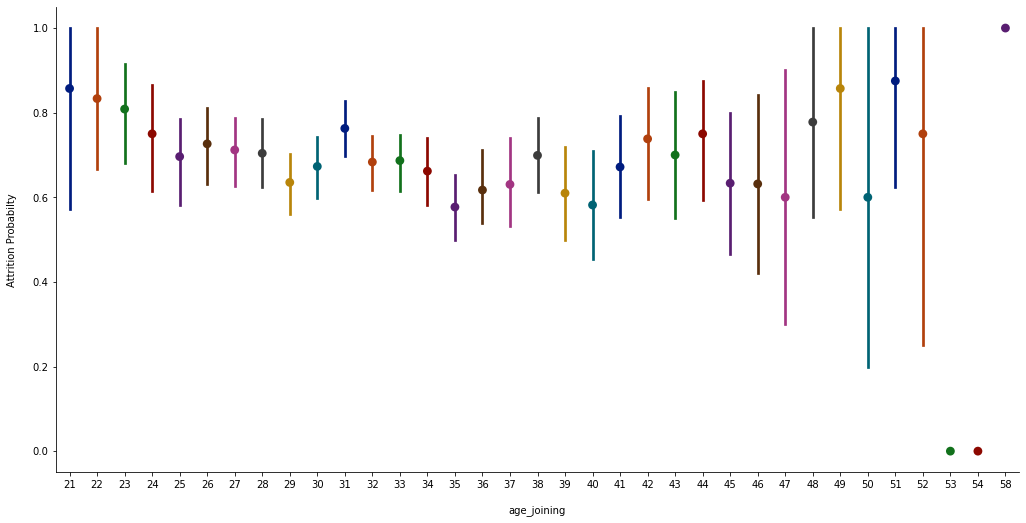

In [66]:
factorplot("age_joining")

Age on last working day

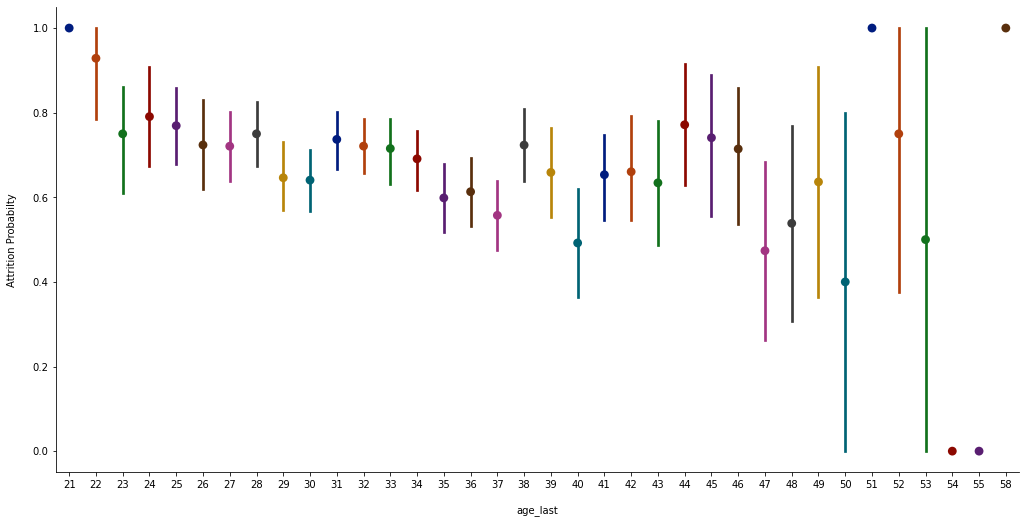

In [67]:
factorplot("age_last")

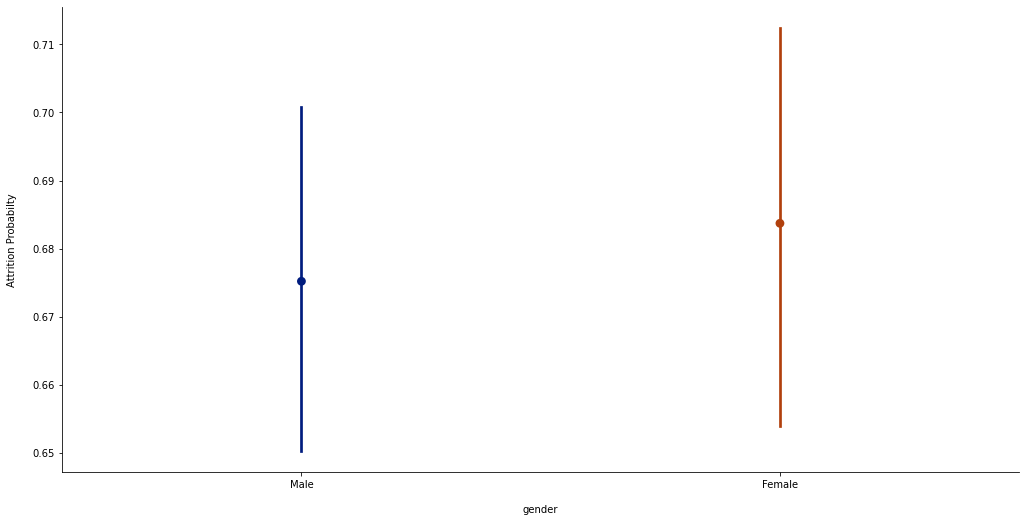

In [68]:
factorplot("gender")

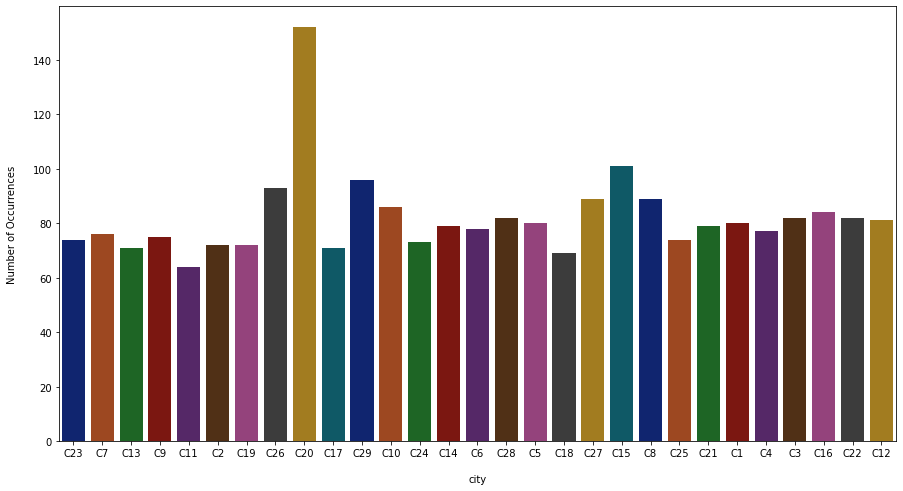

In [69]:
countplot("city")

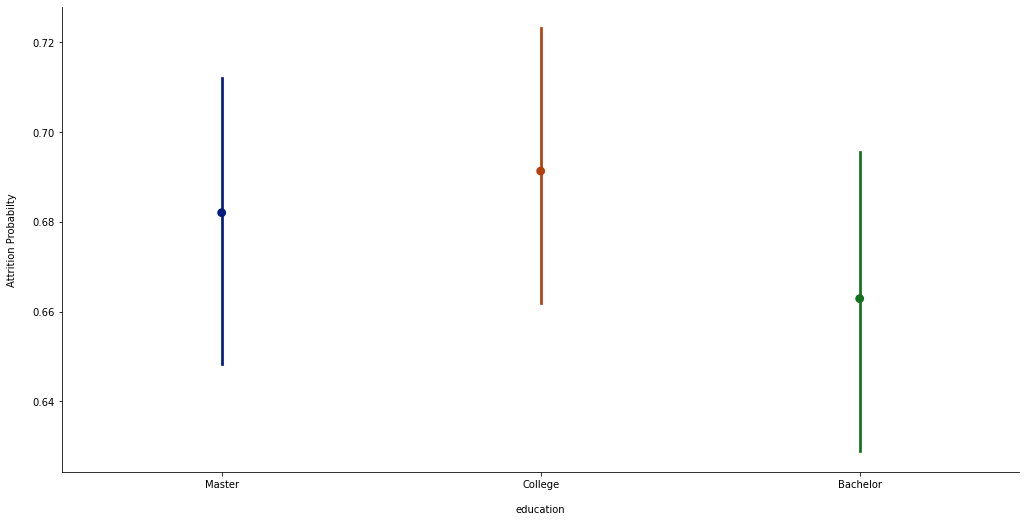

In [70]:
factorplot("education")

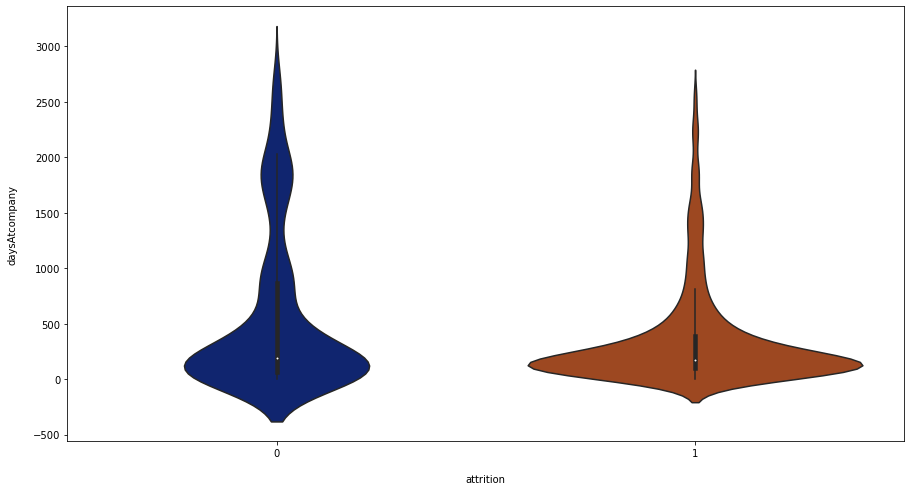

In [71]:
violineplot("daysAtcompany")

In [72]:
df[df.daysAtcompany <=0]

emp_id  age_joining  age_last  gender city education  daysAtcompany  \
220      264           25        25    Male  C11    Master              0   
1026    1207           28        28    Male  C24   College              0   
1344    1581           29        29    Male  C15   College              0   
2041    2397           38        38  Female   C8   College              0   

      average_salary  percentage_hike  got_hike  got_promoted  \
220            49439                0         0             0   
1026           56498                0         0             0   
1344           25873                0         0             0   
2041           47818                0         0             0   

      daysSince_promotion  noOf_promotions  joining_designation  \
220                     0                0                    1   
1026                    0                0                    2   
1344                    0                0                    1   
2041                    0                0                    2   

      current_designation  avg_business_value  ratings  attrition  
220                     1                   0        1          1  
1026                    2                   0        1          1  
1344                    1                   0        1          1  
2041                    2                   0        1          1

Attrition is high in first 500 days

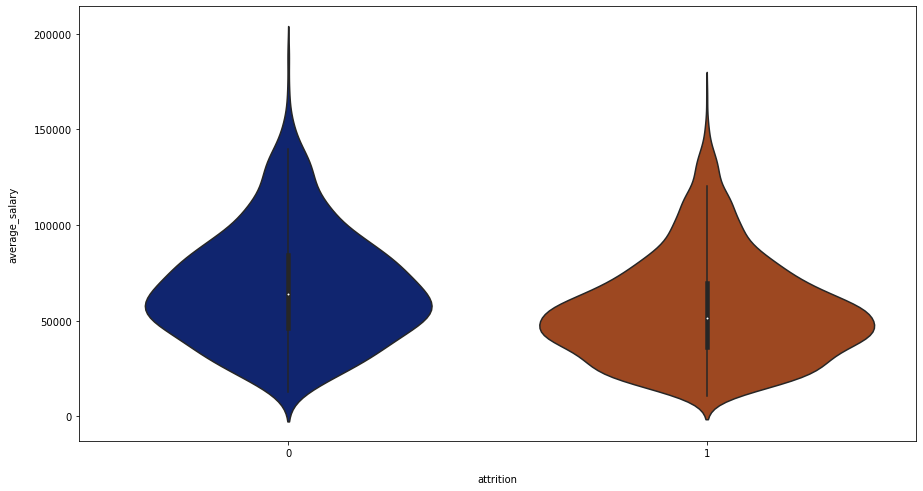

In [73]:
violineplot("average_salary")

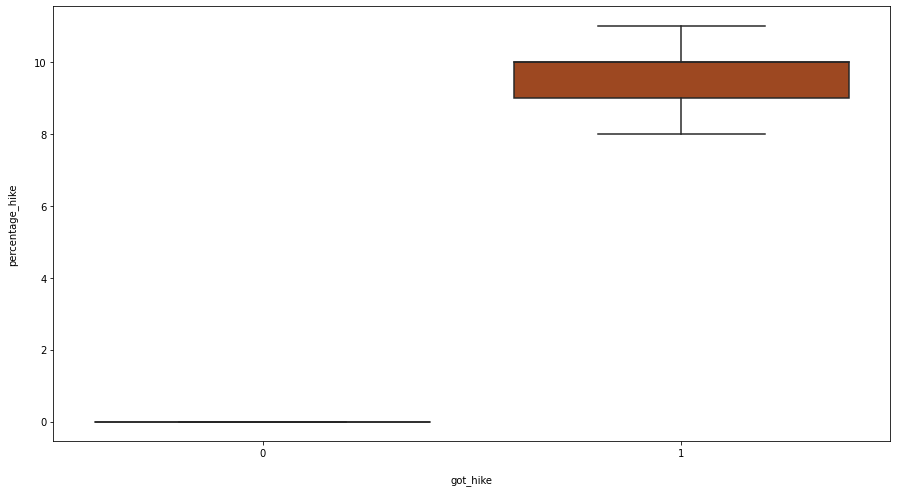

In [74]:
boxplot( "got_hike", "percentage_hike" )

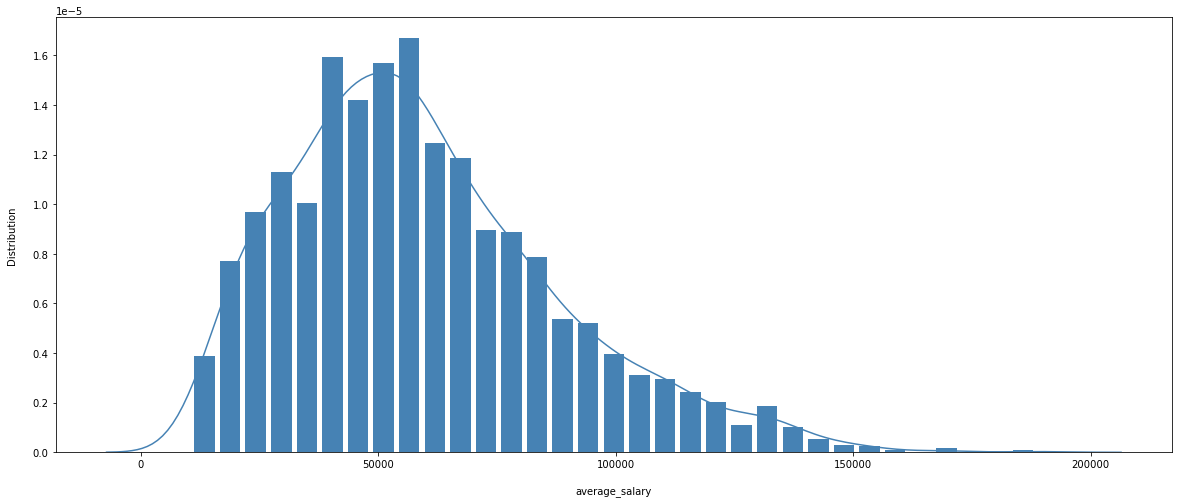

In [75]:
distplot("average_salary")

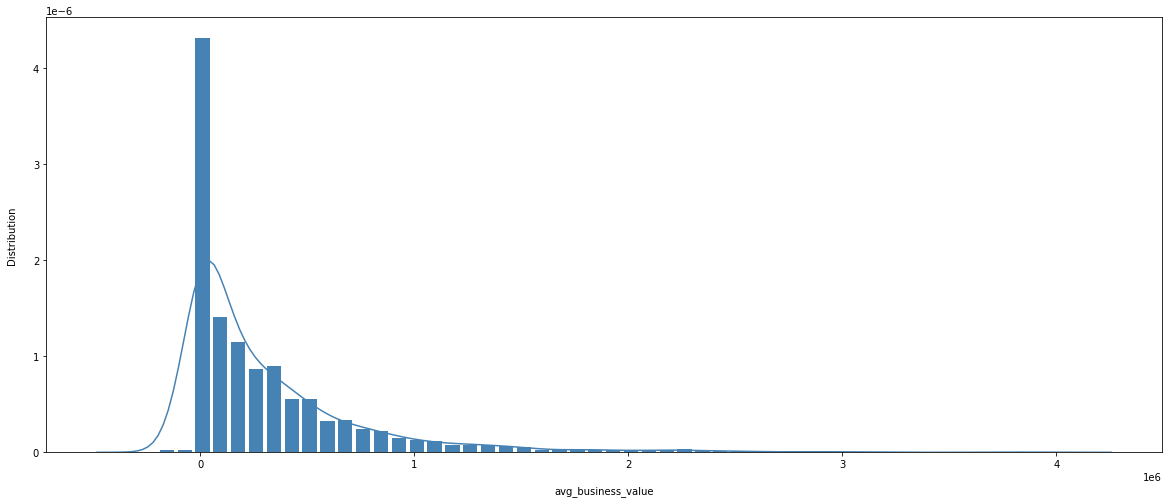

In [76]:
distplot("avg_business_value")

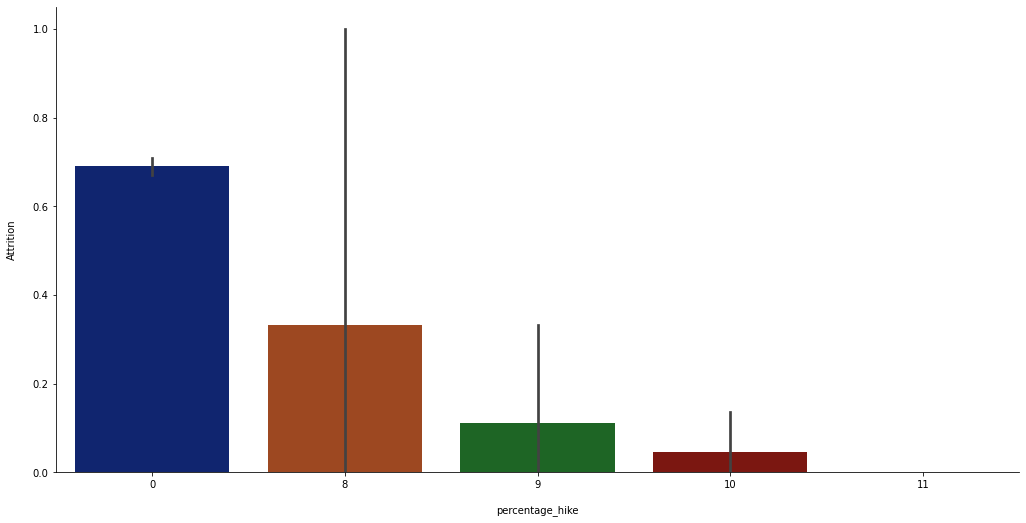

In [77]:
factorplot_bar("percentage_hike")

In [78]:
promotion = df[df.got_promoted ==1]


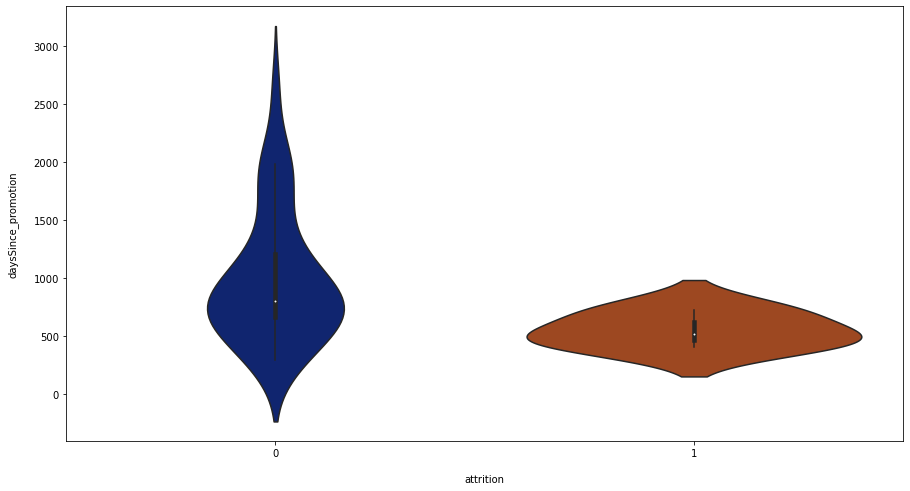

In [79]:
plt.figure(figsize=(15,8))
sns.violinplot(y="daysSince_promotion",data=promotion,x='attrition',palette = "dark")
plt.xlabel('\n'+"attrition")
plt.ylabel("daysSince_promotion"+'\n')
plt.show()



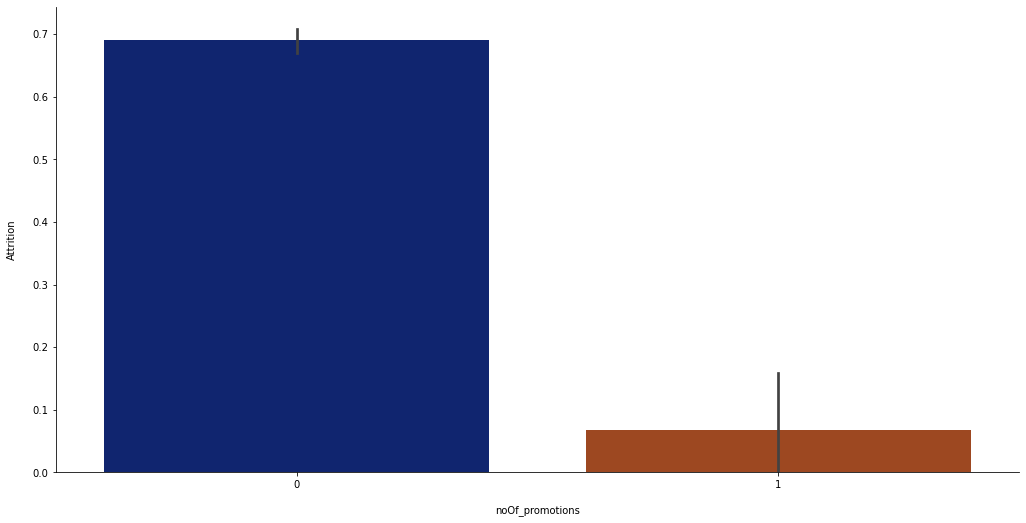

In [80]:
factorplot_bar("noOf_promotions")

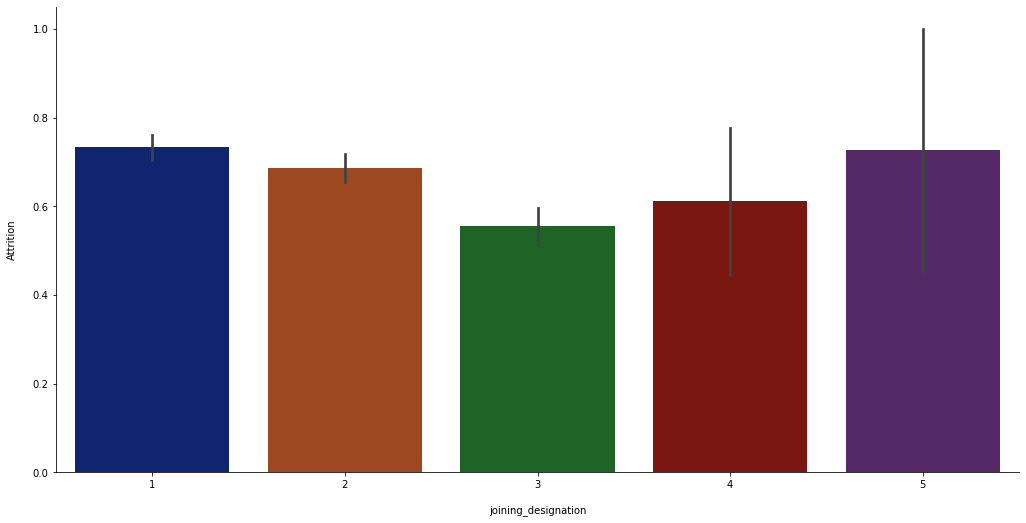

In [81]:
factorplot_bar("joining_designation")

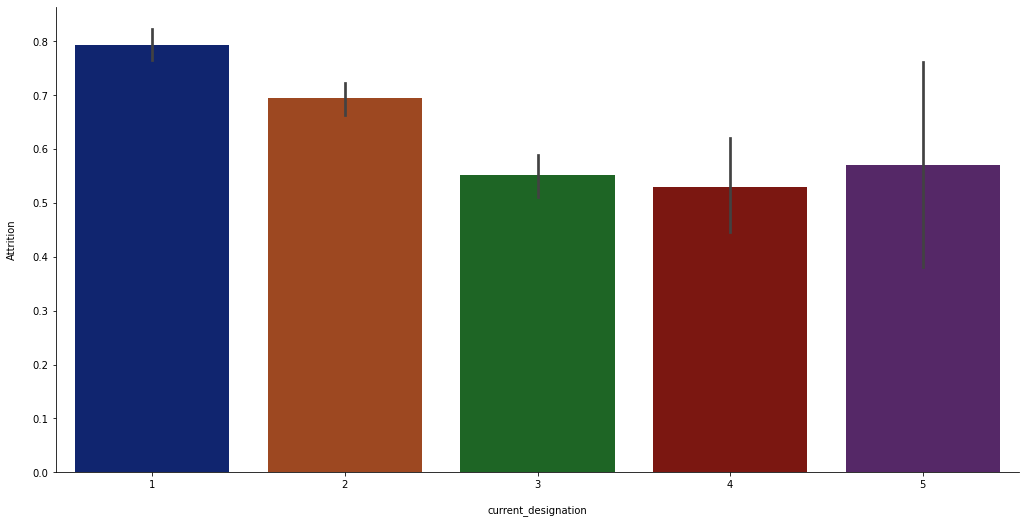

In [82]:
factorplot_bar("current_designation")

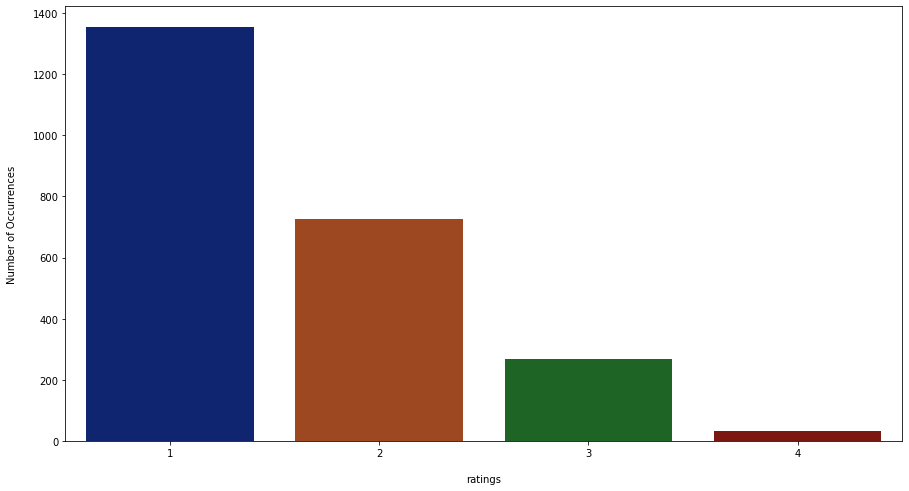

In [83]:
countplot("ratings")

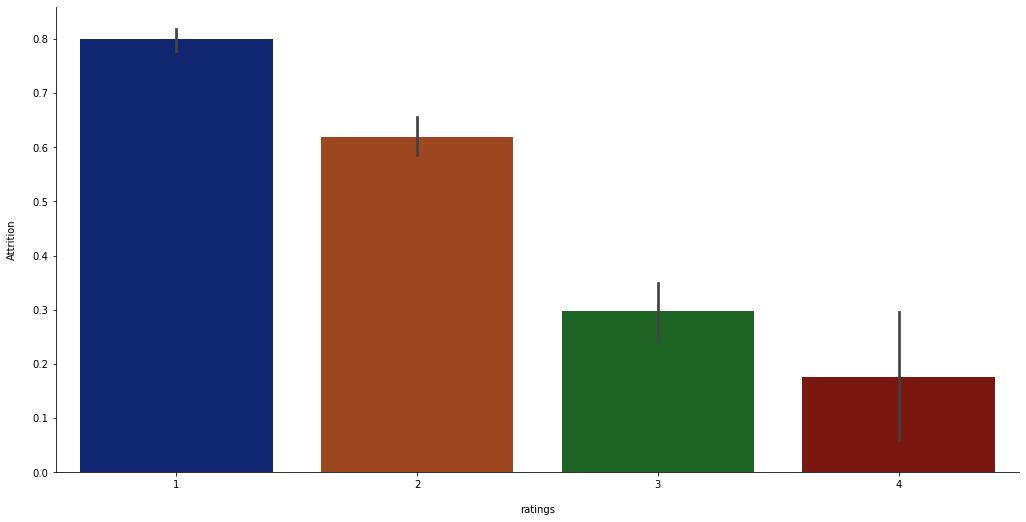

In [84]:
factorplot_bar("ratings")

In [85]:
type_ = ["Attrition", "No Attrition"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=df['attrition'].value_counts(), name="Attrition"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Employee attrition (1: Attrition, 0:No Attrition)",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='attrition', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

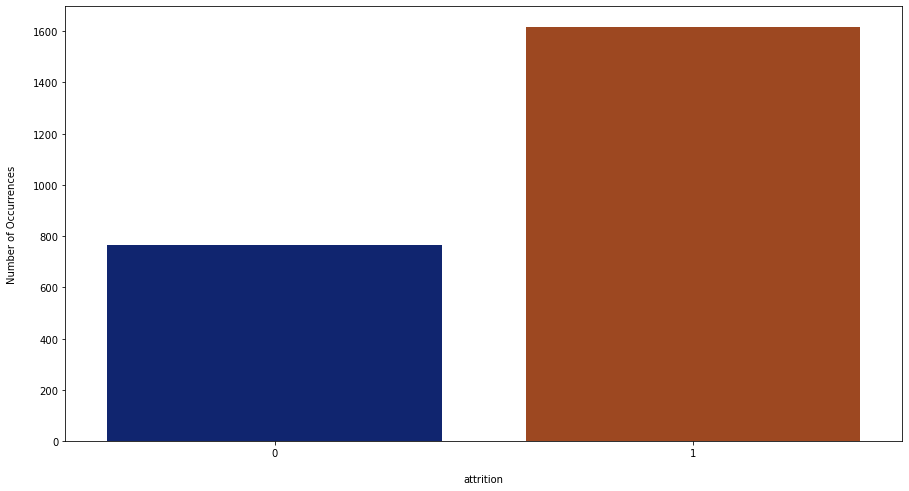

In [86]:
countplot("attrition")

In [87]:
attrition     = df[df["attrition"] == 1]
no_attrition = df[df["attrition"] == 0]

In [88]:
def histogram(column) :
    trace1 = go.Histogram(x  = attrition[column],
                          histnorm= "percent",
                          name = "Employee Attrition",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = no_attrition[column],
                          histnorm = "percent",
                          name = "No Attrition",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace2,trace1]
    layout = go.Layout(dict(title =column + " distribution in employee attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [89]:
histogram("average_salary")

In [90]:
histogram("daysAtcompany")

In [91]:
attrition.columns

Index(['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
       'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike',
       'got_promoted', 'daysSince_promotion', 'noOf_promotions',
       'joining_designation', 'current_designation', 'avg_business_value',
       'ratings', 'attrition'],
      dtype='object')

In [92]:
df.average_salary.describe()

count      2381.000000
mean      59272.611088
std       28325.327533
min       10747.000000
25%       39104.000000
50%       55285.000000
75%       75835.000000
max      188418.000000
Name: average_salary, dtype: float64

In [93]:
df.daysAtcompany.describe()

count    2381.000000
mean      425.189416
std       563.931017
min         0.000000
25%        91.000000
50%       180.000000
75%       468.000000
max      2801.000000
Name: daysAtcompany, dtype: float64

In [94]:
#TODO

# 10k to 50k (Low), 500001 to80k (Medium), >800001 (high)


# Tenure at company :
#0-500 (Low) , 501-1500 (Medium), >1500 (High)

In [95]:
df.dtypes

emp_id                  int64
age_joining             int64
age_last                int64
gender                 object
city                   object
education              object
daysAtcompany           int64
average_salary          int64
percentage_hike         int64
got_hike                int64
got_promoted            int64
daysSince_promotion     int64
noOf_promotions         int64
joining_designation     int64
current_designation     int64
avg_business_value      int64
ratings                 int64
attrition               int64
dtype: object

In [96]:
numerical_features_ = df.describe(include=["int64"]).columns

print(list(numerical_features_))



['emp_id', 'age_joining', 'age_last', 'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike', 'got_promoted', 'daysSince_promotion', 'noOf_promotions', 'joining_designation', 'current_designation', 'avg_business_value', 'ratings', 'attrition']


In [97]:
categorical_features_ = df.describe(include=["object"]).columns

print(list(categorical_features_))

['gender', 'city', 'education']


In [98]:
"""sns.set_style('darkgrid')
sns.pairplot(df[numerical_features_[1:]])
plt.show()"""

"sns.set_style('darkgrid')\nsns.pairplot(df[numerical_features_[1:]])\nplt.show()"

In [99]:
#!pip install imblearn




In [100]:
df = df[['emp_id', 'age_joining', 'age_last', 'gender','education','average_salary',
                             'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
                            'current_designation', 'avg_business_value', 'ratings', 'attrition']]

In [101]:


education_dict = {'College':1,'Bachelor':2, 'Master':3}


df["education"] = df["education"].apply(lambda x: education_dict[x])

In [102]:
df.head()

emp_id  age_joining  age_last  gender  education  average_salary  \
0       1           28        28    Male          3           57387   
1       2           31        31    Male          3           67016   
2       4           43        43    Male          3           65603   
3       5           29        29    Male          1           46368   
4       6           31        31  Female          2           78728   

   daysAtcompany  got_hike  noOf_promotions  joining_designation  \
0             78         0                0                    1   
1             25         0                0                    2   
2            141         0                0                    2   
3             58         0                0                    1   
4            123         0                0                    3   

   current_designation  avg_business_value  ratings  attrition  
0                    1              571860        2          1  
1                    2                   0        1          0  
2                    2               70000        1          1  
3                    1               40120        1          1  
4                    3              253000        2          0

In [103]:
from sklearn.preprocessing import StandardScaler
#one hot encoding: gender and city
# One-Hot encoding 
data_copy= df.copy()
variables = ['gender']
data_copy = pd.get_dummies(data_copy, columns = variables, prefix = variables)


"""#label encoder
from sklearn.preprocessing import LabelEncoder


data_copy= df.copy()
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in data_copy[["city"]]:
    le.fit(data_copy[col])
    data_copy[col] = le.transform(data_copy[col])
    le_count += 1
print('{} columns were label encoded.'.format(le_count))"""

'#label encoder\nfrom sklearn.preprocessing import LabelEncoder\n\n\ndata_copy= df.copy()\nle = LabelEncoder()\n# Label Encoding will be used for columns with 2 or less unique values\nle_count = 0\nfor col in data_copy[["city"]]:\n    le.fit(data_copy[col])\n    data_copy[col] = le.transform(data_copy[col])\n    le_count += 1\nprint(\'{} columns were label encoded.\'.format(le_count))'

In [104]:
data_copy.head()

emp_id  age_joining  age_last  education  average_salary  daysAtcompany  \
0       1           28        28          3           57387             78   
1       2           31        31          3           67016             25   
2       4           43        43          3           65603            141   
3       5           29        29          1           46368             58   
4       6           31        31          2           78728            123   

   got_hike  noOf_promotions  joining_designation  current_designation  \
0         0                0                    1                    1   
1         0                0                    2                    2   
2         0                0                    2                    2   
3         0                0                    1                    1   
4         0                0                    3                    3   

   avg_business_value  ratings  attrition  gender_Female  gender_Male  
0              571860        2          1              0            1  
1                   0        1          0              0            1  
2               70000        1          1              0            1  
3               40120        1          1              0            1  
4              253000        2          0              1            0

In [105]:
data_copy.columns

Index(['emp_id', 'age_joining', 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'attrition',
       'gender_Female', 'gender_Male'],
      dtype='object')

Text(0.5, 1.0, 'Correlation with employee attrition \n')

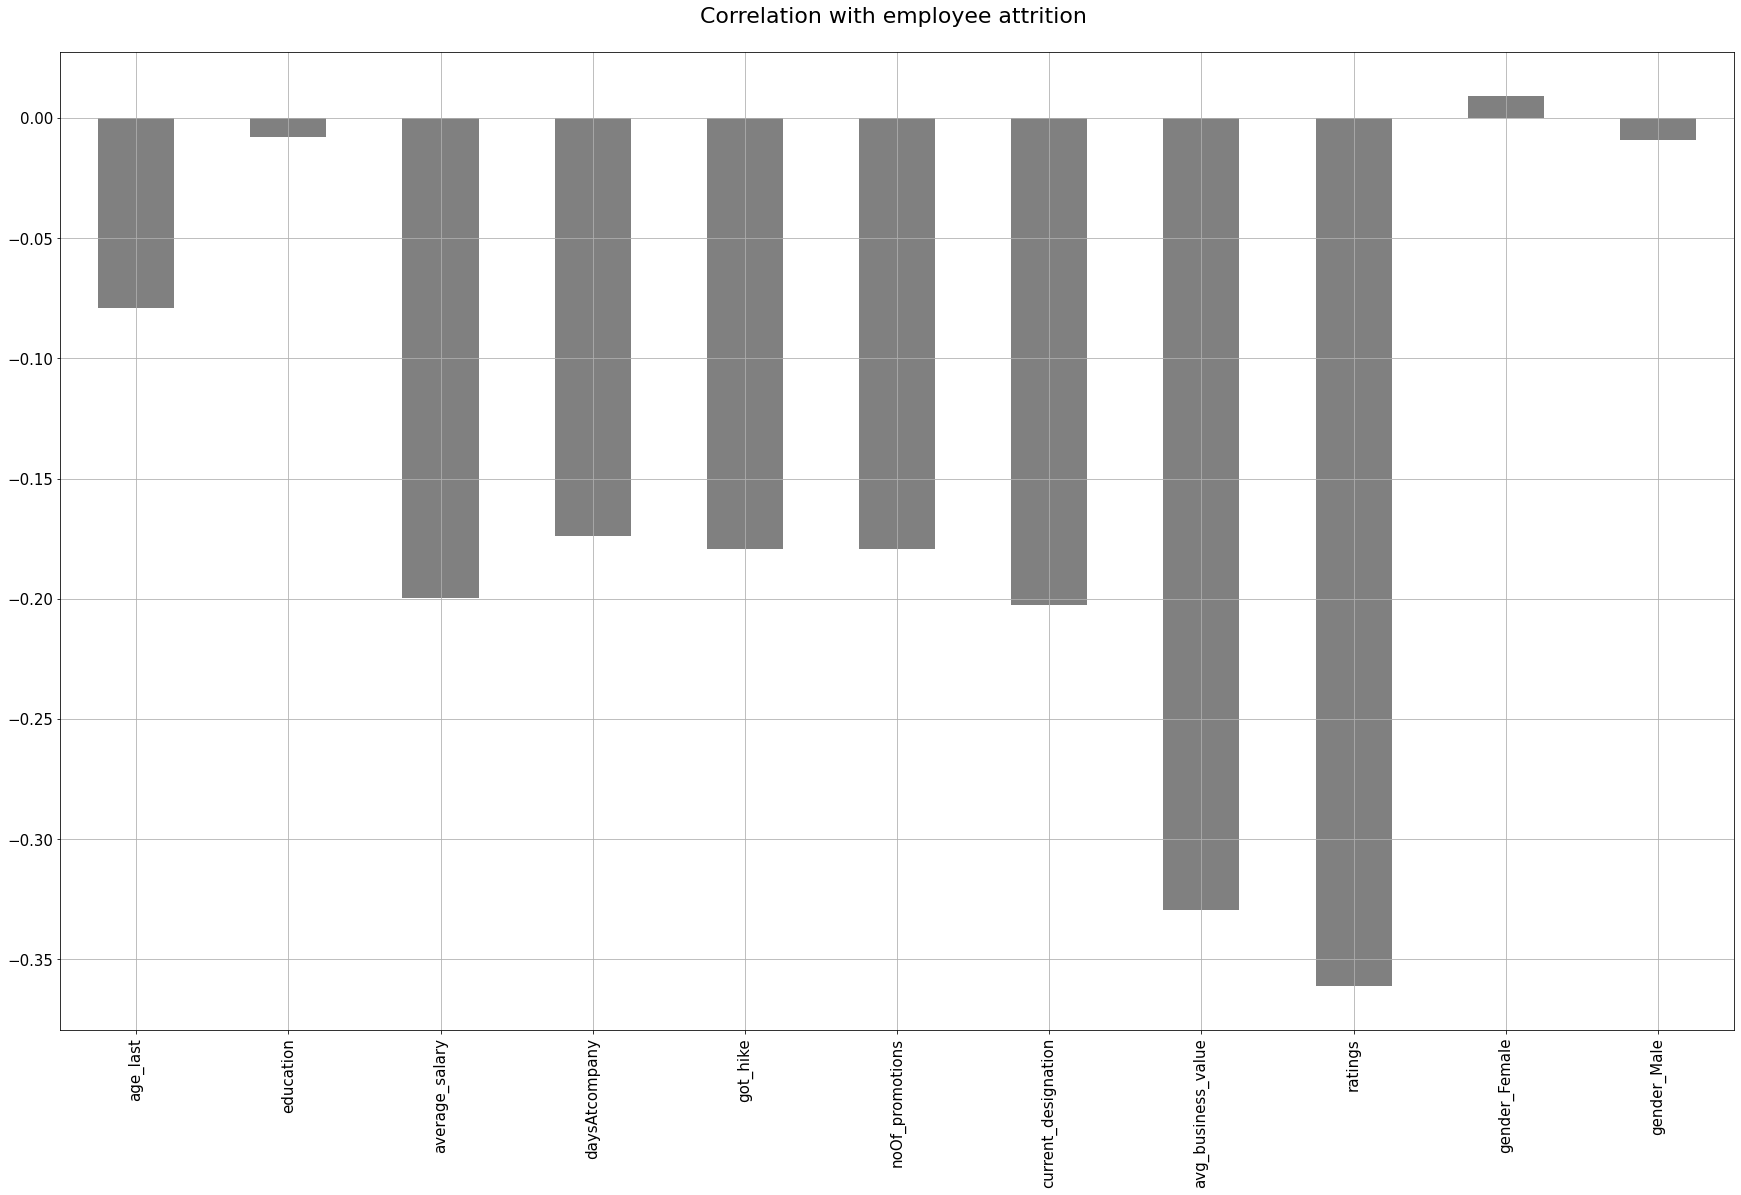

In [106]:
# correlation with attrition


data2 = data_copy[[ 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 
       'current_designation', 'avg_business_value', 'ratings', 
       'gender_Female', 'gender_Male']]

correlations = data2.corrwith(data_copy["attrition"])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (30, 18), 
        fontsize = 15, 
        color = 'grey',
        rot = 90, grid = True)
plt.title('Correlation with employee attrition \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

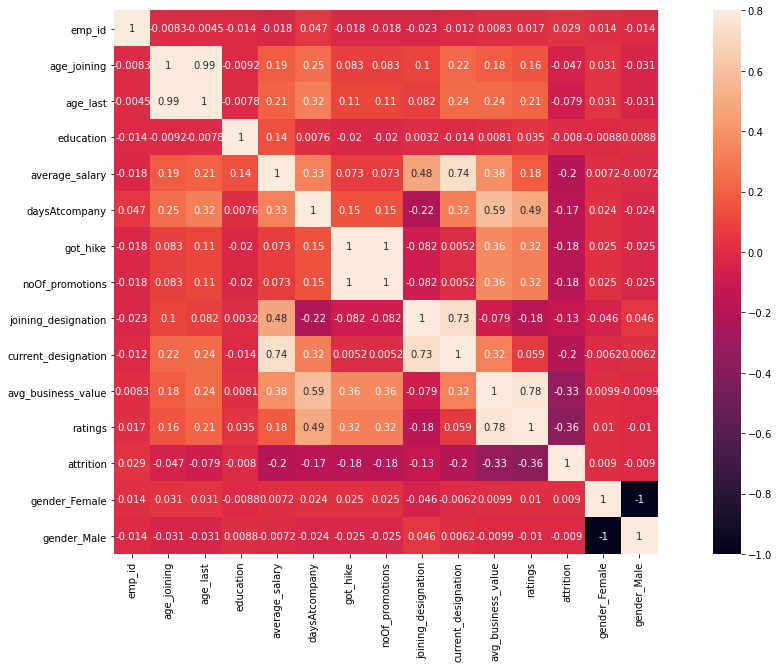

In [107]:
import seaborn as sns
import matplotlib.pyplot as pplt
#correlation matrix
corrmat = data_copy.corr()
f, ax = pplt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

#### Feature importance

In [108]:
y= data_copy.attrition
X = data_copy.drop(["attrition", "emp_id", "age_last"], axis= 1)



features_labels = X.columns



features_labels

Index(['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'gender_Female',
       'gender_Male'],
      dtype='object')

In [109]:

RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
RF.fit(X,y)
features_imp = RF.feature_importances_

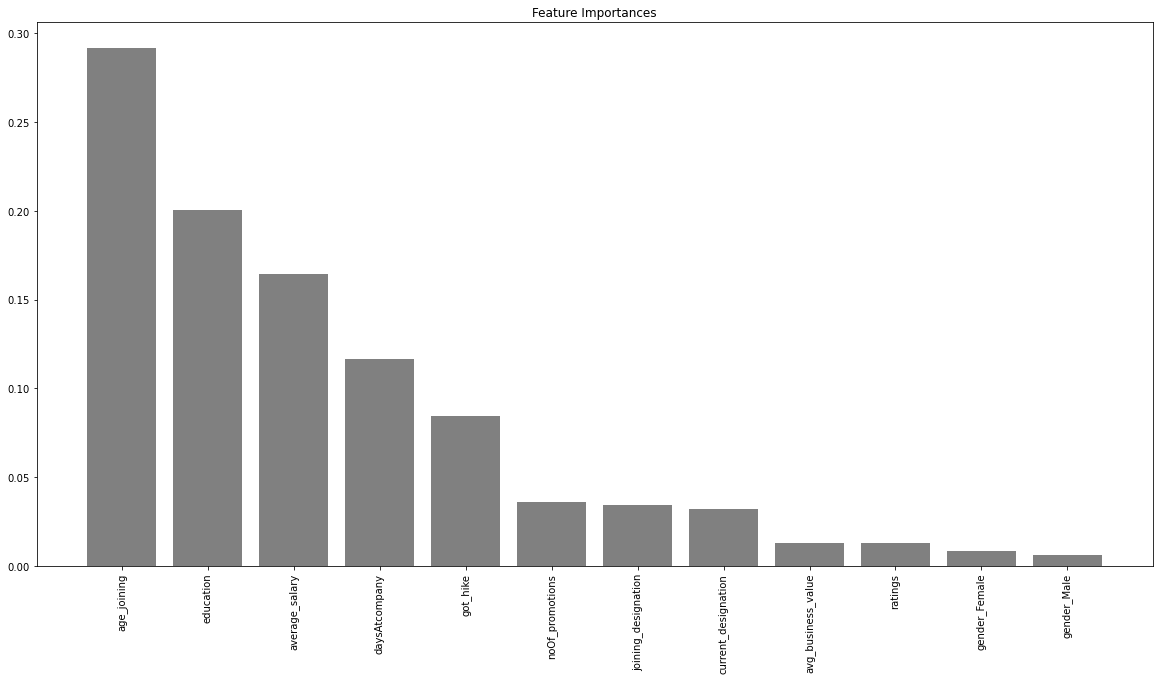

 1) age_joining                    0.291432
 2) education                      0.200277
 3) average_salary                 0.164230
 4) daysAtcompany                  0.116296
 5) got_hike                       0.084726
 6) noOf_promotions                0.035960
 7) joining_designation            0.034531
 8) current_designation            0.032378
 9) avg_business_value             0.012825
10) ratings                        0.012753
11) gender_Female                  0.008423
12) gender_Male                    0.006169


In [110]:
indices = np.argsort(features_imp)[::-1]
plt.subplots(figsize = (20,10)) 
# Visualization
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), features_imp[indices], color = "grey", align = "center")
plt.xticks(range(X.shape[1]), features_labels, rotation = 90)
plt.show()

for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_labels[i], features_imp[indices[i]]))
    

In [111]:
X.iloc[:,:9].columns

Index(['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value'],
      dtype='object')

In [112]:
# Imbalanced data handeling
#random_state=23,0

scaler = StandardScaler()
X = scaler.fit_transform(X.iloc[:,:10])

## Dealing with imbalanced dataset

In [113]:
from imblearn.over_sampling import SMOTE

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1666, 10)
Number transactions y_train dataset:  (1666,)
Number transactions X_test dataset:  (715, 10)
Number transactions y_test dataset:  (715,)


In [115]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1142
Before OverSampling, counts of label '0': 524 



In [116]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())


In [117]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

After OverSampling, the shape of train_X: (2284, 10)
After OverSampling, the shape of train_y: (2284,) 



In [118]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 1142
After OverSampling, counts of label '0': 1142


In [119]:
#Building the baseline models
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=42)

In [120]:
#finding optimal number trees
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train_res, y_train_res.ravel())
    score_array.append(rf_loop.score(X_test,y_test))
    

In [121]:
for i,j in enumerate(score_array):
    print(i+1,":",j)

1 : 0.6867132867132867
2 : 0.6223776223776224
3 : 0.73006993006993
4 : 0.7132867132867133
5 : 0.7510489510489511
6 : 0.7244755244755244
7 : 0.7538461538461538
8 : 0.7286713286713287
9 : 0.7496503496503496
10 : 0.7412587412587412
11 : 0.7482517482517482
12 : 0.7454545454545455
13 : 0.7566433566433567
14 : 0.7524475524475525
15 : 0.765034965034965
16 : 0.7538461538461538
17 : 0.7594405594405594
18 : 0.7594405594405594
19 : 0.7594405594405594
20 : 0.7608391608391608
21 : 0.765034965034965
22 : 0.7706293706293706
23 : 0.7748251748251749
24 : 0.7692307692307693
25 : 0.772027972027972
26 : 0.7636363636363637
27 : 0.7664335664335664
28 : 0.7664335664335664
29 : 0.7622377622377622
30 : 0.765034965034965
31 : 0.7692307692307693
32 : 0.772027972027972
33 : 0.7678321678321678
34 : 0.7706293706293706
35 : 0.7678321678321678
36 : 0.772027972027972
37 : 0.772027972027972
38 : 0.7706293706293706
39 : 0.772027972027972
40 : 0.7692307692307693
41 : 0.765034965034965
42 : 0.7678321678321678
43 : 0.77342

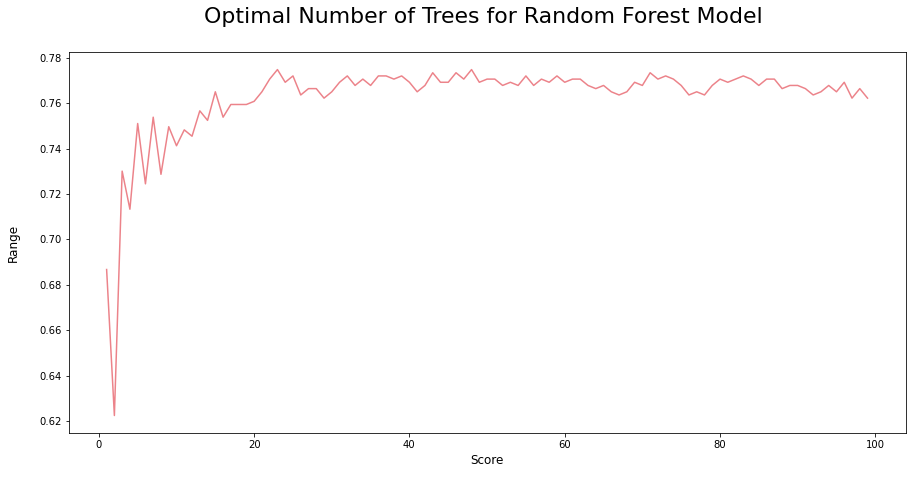

In [122]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Logistic Regression

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [124]:
lr1 = LogisticRegression(C=4,penalty='l1', verbose=5, solver='liblinear')
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=4, penalty='l1', solver='liblinear', verbose=5)

In [125]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()


Recall metric in the train dataset: 73.90542907180385%


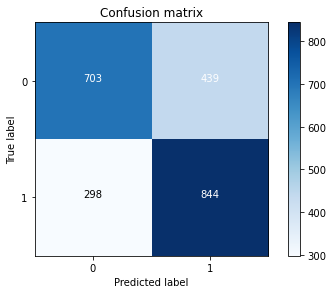

In [126]:
y_train_pre = lr1.predict(X_train_res)

cnf_matrix_tra = confusion_matrix(y_train_res, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [127]:
from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_pre))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1142
           1       0.66      0.74      0.70      1142

    accuracy                           0.68      2284
   macro avg       0.68      0.68      0.68      2284
weighted avg       0.68      0.68      0.68      2284



In [128]:
#test
test_data  =pd.read_csv("test.csv")

test_emp_ids = test_data.Emp_ID.values
len(test_emp_ids)

test_ids = data_copy[data_copy['emp_id'].isin(test_emp_ids)]
test_ids.shape
test_ids.columns




Index(['emp_id', 'age_joining', 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'attrition',
       'gender_Female', 'gender_Male'],
      dtype='object')

In [129]:


y_test_results = test_ids.attrition

test_ids.columns
X_test_data =test_ids[['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'current_designation','joining_designation',
       'avg_business_value', 'ratings']]
X_test_data

age_joining  education  average_salary  daysAtcompany  got_hike  \
1              31          3           67016             25         0   
4              31          2           78728            123         0   
6              28          3           42172              6         0   
9              39          1           19734             46         0   
17             29          2          102077           1128         0   
...           ...        ...             ...            ...       ...   
2370           27          1           85112             60         0   
2372           35          3           50180              2         0   
2374           25          3           46952            287         0   
2376           33          1           82815           1873         0   
2380           29          3           70254            176         0   

      noOf_promotions  current_designation  joining_designation  \
1                   0                    2                    2   
4                   0                    3                    3   
6                   0                    1                    1   
9                   0                    3                    3   
17                  0                    3                    1   
...               ...                  ...                  ...   
2370                0                    3                    3   
2372                0                    2                    2   
2374                0                    2                    2   
2376                0                    3                    2   
2380                0                    2                    2   

      avg_business_value  ratings  
1                      0        1  
4                 253000        2  
6                      0        1  
9                      0        1  
17               1514630        4  
...                  ...      ...  
2370                   0        1  
2372                   0        1  
2374              784852        3  
2376              906201        3  
2380              328320        2  

[741 rows x 10 columns]

<AxesSubplot:>

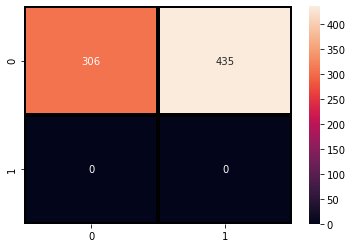

In [130]:



scaler_ = StandardScaler()
X_test_data = scaler_.fit_transform(X_test_data)


pred_lr1_test = lr1.predict(X_test_data)
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_lr1_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

In [131]:
from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_lr1_test)
accuracy_final

0.41295546558704455

### Random Forest

In [132]:
#Random Forest
rf_test = {"max_depth": [4,6,8,10],
           "max_features": [6,8,10],
           "min_samples_split": [3,4,5],
           "min_samples_leaf": [3,4,5],
           "bootstrap": [True],
           "n_estimators" :[125],
           "criterion": ["gini","entropy"],
           "max_leaf_nodes":[20,22,24,26],
           "min_impurity_decrease":[0.0],
           "min_weight_fraction_leaf":[0.0]}

tuning = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_test, scoring = 'accuracy', n_jobs = 6, cv = 5, verbose=1)

tuning.fit(X_train_res,np.ravel(y_train_res))

rf_best = tuning.best_estimator_

tuning.best_score_





Fitting 5 folds for each of 864 candidates, totalling 4320 fits


0.7968472878037545

In [133]:
tuning.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 6,
 'max_leaf_nodes': 26,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 125}

Recall metric in the train dataset: 73.90542907180385%


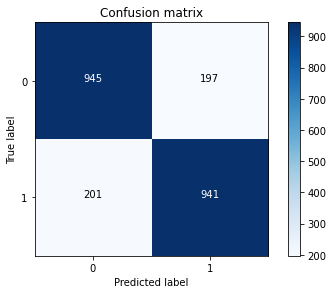

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1142
           1       0.83      0.82      0.83      1142

    accuracy                           0.83      2284
   macro avg       0.83      0.83      0.83      2284
weighted avg       0.83      0.83      0.83      2284



In [134]:
y_train_rf = rf_best.predict(X_train_res)

cnf_matrix_rf = confusion_matrix(y_train_res, y_train_rf)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_rf))





In [135]:
pred_rf_test = rf_best.predict(X_test_data)




0.6842105263157895

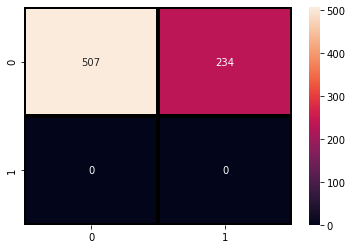

In [136]:
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_rf_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_rf_test)
accuracy_final





In [137]:
test_data["Target"] = pred_rf_test

test_data.to_csv("sumission_rftest2.csv")


## Selecting the classification model based on f1 score

In [138]:
from xgboost import XGBClassifier as XGBC
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, classification_report, precision_recall_curve,f1_score

In [139]:
def Classification_model(model,X_train_res,y_train_res,X_test,y_test): # here x is the variable which are used for prediction    # y is the supervision variable
   
    
    model.fit(X_train_res,y_train_res.ravel())
    pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    recall = recall_score(y_test,pred)
    precision = precision_score(y_test,pred)
    F1_score = f1_score(y_test,pred)
    return accuracy, recall, precision, F1_score




In [140]:
# Lets us make a list of models
models=["XGBClassifier","RandomForestClassifier","Gaussian Naive Bays","KNN","Logistic_Regression","Support_Vector"]
Classification_models = [XGBC(n_estimators=100),RandomForestClassifier(n_estimators=100),GB(),knn(n_neighbors=7),LogisticRegression(),SVC()]
Model_Accuracy = []
Model_Recall = []
Model_Precision = []
Model_f1 = []


In [141]:
for model in Classification_models:
    Accuracy,Recall, Precision, F1_score = Classification_model(model,X_train_res,y_train_res,X_test,y_test)    #,Recall, Precision, F1_score
    Model_Accuracy.append(Accuracy)
    Model_Recall.append(Recall)
    Model_Precision.append(Precision)
    Model_f1.append(F1_score)

[22:44:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [142]:
Accuracy_with_Imp_features = pd.DataFrame(
    { "Classification Model" :models,
     "Accuracy with Imp features":Model_Accuracy, "Recall with Imp features":Model_Recall, "Precision with Imp features":Model_Precision, 
     "F1 with Imp features":Model_f1})

In [143]:
Accuracy_with_Imp_features.sort_values(by="Accuracy with Imp features",ascending=False).reset_index(drop=True)

Classification Model  Accuracy with Imp features  \
0           XGBClassifier                    0.783217   
1  RandomForestClassifier                    0.765035   
2     Gaussian Naive Bays                    0.734266   
3          Support_Vector                    0.727273   
4     Logistic_Regression                    0.721678   
5                     KNN                    0.678322   

   Recall with Imp features  Precision with Imp features  F1 with Imp features  
0                  0.839662                     0.834382              0.837014  
1                  0.799578                     0.838496              0.818575  
2                  0.943038                     0.732787              0.824723  
3                  0.744726                     0.826698              0.783574  
4                  0.748945                     0.816092              0.781078  
5                  0.679325                     0.805000              0.736842

xgboost seems to work well

## XGBoost: model1

In [144]:
# XGBOOSt
from xgboost import XGBClassifier
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1], 
                  'max_depth': [3,4],
                  'n_estimators': [130]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[22:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8056086606011746

Recall metric in the train dataset: 89.92994746059544%


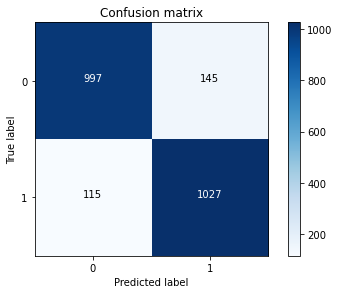

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1142
           1       0.88      0.90      0.89      1142

    accuracy                           0.89      2284
   macro avg       0.89      0.89      0.89      2284
weighted avg       0.89      0.89      0.89      2284



In [145]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))





In [146]:
#test

pred_xgb_test = xgb_best.predict(X_test_data)



0.7827260458839406

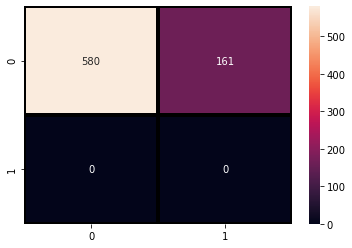

In [147]:

#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final





In [148]:
test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")


## XGBOOSt:130: 57.044

### XGB model parameter tuning


In [149]:
# XGBOOSt
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.2], 
                  'max_depth': [3,4,5],
                  'n_estimators': [131]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[22:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8191811585857423

Recall metric in the train dataset: 96.58493870402802%


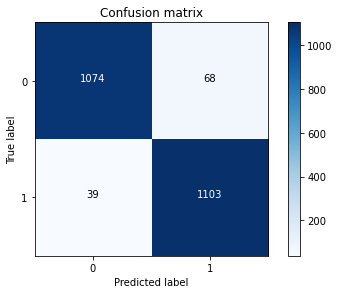

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1142
           1       0.94      0.97      0.95      1142

    accuracy                           0.95      2284
   macro avg       0.95      0.95      0.95      2284
weighted avg       0.95      0.95      0.95      2284



In [150]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))





In [151]:
#test

pred_xgb_test = xgb_best.predict(X_test_data)



0.8232118758434548

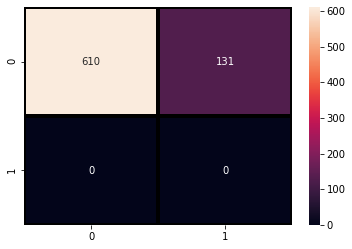

In [152]:

#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final



In [153]:
test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")



## Final model with 61.20

In [463]:
# XGBOOSt
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1], 
                  'max_depth': [3,4,5],
                  'n_estimators': [200]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.812172252293754

Recall metric in the train dataset: 97.28546409807356%


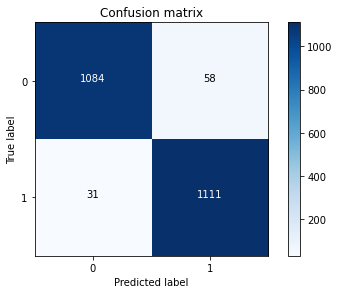

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1142
           1       0.95      0.97      0.96      1142

    accuracy                           0.96      2284
   macro avg       0.96      0.96      0.96      2284
weighted avg       0.96      0.96      0.96      2284



In [464]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))







In [465]:
#test


pred_xgb_test = xgb_best.predict(X_test_data)


0.8232118758434548

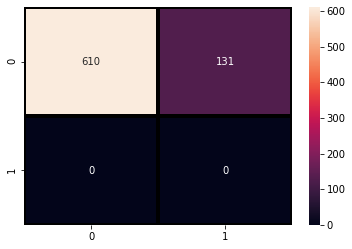

In [466]:
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final




### Output file

In [467]:

test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")






In [ ]:
"""
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=160, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_res, y_train_res)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_res, y_train_res)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()"""